# At first let's see what we will need

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import googleapiclient.discovery as api
import datetime as dt
import time
import pymystem3
import stop_words
import re
from sklearn.feature_extraction.text import CountVectorizer
from randan.descriptive_statistics import ScaleStatistics
from randan.dimension_reduction import PCA
from randan.bivariate_association import Correlation
from randan.bivariate_association import Crosstab
import dostoevsky
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [2]:
API_KEY = "" # put here your API KEY
api_service_name = "youtube"
api_version = "v3"

youtube = api.build(api_service_name,
    api_version,
    developerKey = API_KEY)

In [3]:
part = "snippet"
q = "" # Use here your q you looking for
type_v = "video"
amount = 50
order_list = ['rating', 'date', 'title', 'videoCount', 'viewCount', 'relevance']

In [4]:
request = youtube.search().list(part = part,
                                maxResults = amount,
                                q = q,
                                type = type_v)
response = request.execute()
response

df_supplemented = pd.json_normalize(response['items'])

# Collect all needed data for analysis

In [6]:
i = 0 
for order in order_list:
    if len(df_supplemented.drop_duplicates(f'id.{type_v}Id')) < response['pageInfo']['totalResults']: 
        request = youtube.search().list(
            part = part,
            maxResults = amount,
            q = q,
            type = type_v,
            order = order)
        response = request.execute()

        print(f'Iteration №{i}')
        i += 1
        
        df_fr = pd.json_normalize(response['items'])
        df_supplemented = pd.concat([df_supplemented, df_fr]) 
        
        while ('nextPageToken' in response.keys())\
        & (len(df_supplemented.drop_duplicates(f'id.{type_v}Id')) < response['pageInfo']['totalResults'])\
        & (len(response["items"]) > 0):
            request = youtube.search().list(
                part = part,
                maxResults = amount,
                q = q,
                type = type_v,
                pageToken = response['nextPageToken'],
                order = order
            )
            response = request.execute()
            
            print(f'iteration № {i}')
            i += 1
            
            df_add = pd.json_normalize(response['items'])
            df_supplemented = pd.concat([df_supplemented, df_add]) 
        
    else:
        print('everything found without using order arguments')

Iteration №0
iteration i № 1
iteration i № 2
iteration i № 3
iteration i № 4
iteration i № 5
Iteration №6
iteration i № 7
iteration i № 8
iteration i № 9
iteration i № 10
iteration i № 11
iteration i № 12
iteration i № 13
iteration i № 14
iteration i № 15
iteration i № 16
Iteration №17
iteration i № 18
iteration i № 19
iteration i № 20
iteration i № 21
iteration i № 22
iteration i № 23
iteration i № 24
iteration i № 25
iteration i № 26
iteration i № 27
Iteration №28
iteration i № 29
iteration i № 30
iteration i № 31
iteration i № 32
iteration i № 33
iteration i № 34
iteration i № 35
iteration i № 36
iteration i № 37
iteration i № 38
Iteration №39
iteration i № 40
iteration i № 41
iteration i № 42
iteration i № 43
iteration i № 44
iteration i № 45
iteration i № 46
iteration i № 47
iteration i № 48
iteration i № 49
Iteration №50
iteration i № 51
iteration i № 52
iteration i № 53
iteration i № 54
iteration i № 55
iteration i № 56
iteration i № 57
iteration i № 58
iteration i № 59
iteratio

In [7]:
df_supplemented = df_supplemented.drop_duplicates(f'id.{type_v}Id')
df_supplemented.index = range(1, len(df_supplemented) + 1)
display(df_supplemented)

,kind,etag,id.kind,id.videoId,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,snippet.thumbnails.medium.url,snippet.thumbnails.medium.width,snippet.thumbnails.medium.height,snippet.thumbnails.high.url,snippet.thumbnails.high.width,snippet.thumbnails.high.height,snippet.channelTitle,snippet.liveBroadcastContent,snippet.publishTime
1,youtube#searchResult,BnZfYOGgbPQHWYwK1MrAdIZ2uUA,youtube#video,DsWQpYf3Kbc,2022-06-01T08:55:15Z,UCCROBQj3rdGNc-E_aMpbV_A,Импортозамещение в России: реальные цифры,Научись создавать сайты и приложения на Python...,https://i.ytimg.com/vi/DsWQpYf3Kbc/default.jpg,120,90,https://i.ytimg.com/vi/DsWQpYf3Kbc/mqdefault.jpg,320,180,https://i.ytimg.com/vi/DsWQpYf3Kbc/hqdefault.jpg,480,360,MyGap,none,2022-06-01T08:55:15Z
2,youtube#searchResult,CDrg_g1KiwoqoLKxBgp1G6dliHo,youtube#video,Midft6y8330,2024-05-24T14:26:45Z,UC8qjk39Hk7i8i7VUNnWVVNQ,ПЕРВАЯ РОССИЙСКАЯ ИГРОВАЯ ПРИСТАВКА! ИМПОРТОЗА...,Подавайте заявку в онлайн-магистратуру Информа...,https://i.ytimg.com/vi/Midft6y8330/default.jpg,120,90,https://i.ytimg.com/vi/Midft6y8330/mqdefault.jpg,320,180,https://i.ytimg.com/vi/Midft6y8330/hqdefault.jpg,480,360,EVG,none,2024-05-24T14:26:45Z
3,youtube#searchResult,lN_k8aS7AchJFeuV3Cj3LKTykzQ,youtube#video,oahrl7aXKvI,2023-09-28T12:03:57Z,UC101o-vQ2iOj9vr00JUlyKw,«Барби» из Казахстана и китайский «Москвич»: п...,"Добрый кола, китайский «Москвич» и «Барби» под...",https://i.ytimg.com/vi/oahrl7aXKvI/default.jpg,120,90,https://i.ytimg.com/vi/oahrl7aXKvI/mqdefault.jpg,320,180,https://i.ytimg.com/vi/oahrl7aXKvI/hqdefault.jpg,480,360,varlamov,none,2023-09-28T12:03:57Z
4,youtube#searchResult,4LLARhLfUNMR9BwnftNNcKOZwto,youtube#video,O5uRZX7a0yY,2019-04-21T12:00:03Z,UCgxTPTFbIbCWfTR9I2-5SeQ,Милов: Импортозамещение привело к росту цен,"Владимир Милов рассказывает, как курс на импор...",https://i.ytimg.com/vi/O5uRZX7a0yY/default.jpg,120,90,https://i.ytimg.com/vi/O5uRZX7a0yY/mqdefault.jpg,320,180,https://i.ytimg.com/vi/O5uRZX7a0yY/hqdefault.jpg,480,360,Навальный LIVE,none,2019-04-21T12:00:03Z
5,youtube#searchResult,l4qW7KsjiPse7fDYrEXQXgPHDG4,youtube#video,JaoqFhpvfh8,2023-01-20T10:29:23Z,UC8qjk39Hk7i8i7VUNnWVVNQ,Российское ИМПОРТОЗАМЕЩЕНИЕ WINDOWS! Наш Ответ...,Курс “Профессия Специалист по кибербезопасност...,https://i.ytimg.com/vi/JaoqFhpvfh8/default.jpg,120,90,https://i.ytimg.com/vi/JaoqFhpvfh8/mqdefault.jpg,320,180,https://i.ytimg.com/vi/JaoqFhpvfh8/hqdefault.jpg,480,360,EVG,none,2023-01-20T10:29:23Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,youtube#searchResult,Jj5jmgPXzkF61SIGv89t_OQvOiY,youtube#video,JYpZj3icvaw,2024-06-18T21:41:43Z,UChExZAOm4KAZS3UzN7lrgsA,Первый день выставки Rosmould (18.06.2024),Регистрация на выставку Rosmould: https://onli...,https://i.ytimg.com/vi/JYpZj3icvaw/default.jpg,120,90,https://i.ytimg.com/vi/JYpZj3icvaw/mqdefault.jpg,320,180,https://i.ytimg.com/vi/JYpZj3icvaw/hqdefault.jpg,480,360,Rosmould | 3D-TECH,none,2024-06-18T21:41:43Z
901,youtube#searchResult,HAbncXSyqUwFxtKqil8YKfxZbXw,youtube#video,_WWj1MWL_54,2024-06-13T15:00:07Z,UCa85JIfBxZgcrsd8Ar7Z9nw,Кадыров НАЦЕЛИЛСЯ на Польшу? Грозный вояка зап...,Когда в начале мая 2024 года некто Дон Дыров н...,https://i.ytimg.com/vi/_WWj1MWL_54/default.jpg,120,90,https://i.ytimg.com/vi/_WWj1MWL_54/mqdefault.jpg,320,180,https://i.ytimg.com/vi/_WWj1MWL_54/hqdefault.jpg,480,360,Телеканал ICTV,none,2024-06-13T15:00:07Z
902,youtube#searchResult,xEtf7JN11uJONDbuzscPavBE9tw,youtube#video,Ss0ldMhsU_M,2024-06-18T18:00:14Z,UChExZAOm4KAZS3UzN7lrgsA,Деталь спекается,shorts.,https://i.ytimg.com/vi/Ss0ldMhsU_M/default.jpg,120,90,https://i.ytimg.com/vi/Ss0ldMhsU_M/mqdefault.jpg,320,180,https://i.ytimg.com/vi/Ss0ldMhsU_M/hqdefault.jpg,480,360,Rosmould | 3D-TECH,none,2024-06-18T18:00:14Z
903,youtube#searchResult,SHa0ky34QEad6Esh-6Hf9CzgFkI,youtube#video,ixfs8ioMVFs,2024-06-22T14:00:37Z,UChExZAOm4KAZS3UzN7lr

In [8]:
df_local = df_supplemented
videoId = df_local[f'id.{type_v}Id'].to_list()
videoId

['DsWQpYf3Kbc',
 'Midft6y8330',
 'oahrl7aXKvI',
 'O5uRZX7a0yY',
 'JaoqFhpvfh8',
 'dU9LKIfhIXY',
 'Glnmc78o-vE',
 'qoufaldXefY',
 'mcrk0Jzsi5s',
 'ctuOpCMIzDg',
 'x9VteD_RFg0',
 'vLnnLvYcJt8',
 'VQNIs0fL76A',
 '5r2I29Kn3oQ',
 '0gdCR1HrA_Y',
 'N-I-tz9VC9Q',
 'ylQEi8INpNw',
 '0eeg1pvGjFc',
 '-XRzdMFtNa0',
 'znGKTPr0d_Y',
 'hTxOs_qEYJo',
 'TYo8weESz44',
 'B_mO4J0DOks',
 'WNJavxSYEE8',
 '2lgWxVMbGeE',
 'yBS3WVtBTc0',
 'j1TN55LQ3zE',
 'pM2i1UdMFZU',
 'JRuTofOvhiE',
 'uJnJDR2nk74',
 'ywvER0olquA',
 'GBxphZDt5_0',
 'k4uaMsTcwgo',
 'kqjg5LDqNlM',
 'FGH6eD0gg4s',
 '1CDKcJHMTW0',
 'EKDvWEQamZg',
 'gsb_yt9oiQ4',
 'guPfgFL5eu0',
 'o_7UsxQ1bx0',
 'tmAlVrkdKcw',
 'XYBarWORm6M',
 'zJGDBvtykpw',
 'A07A2MN_fVM',
 'bOfAZZk7ifM',
 '3UplAryNcIU',
 'ULVSkFQY-1M',
 '8wEn6UgOvos',
 'nOI8TRKPaEc',
 'hYyPTBt48Hc',
 'N8jsFlyRhvI',
 'YL9JlmFJzmQ',
 '9cD3sslrNrQ',
 'mNq2VPMego8',
 'zctT1xleE-k',
 'kCQOFeN6K0c',
 'EU_lP0cOBZg',
 'k0BU4yVNqd8',
 'zhbBPfcSRxc',
 '-r4htJ-cUzQ',
 'nmqmyIusl_Q',
 'wfrmfhWUSec',
 '57Eine

In [9]:
request = youtube.videos().list(
    part = [
        "snippet",
        "contentDetails",
        "statistics",  
        "topicDetails"],
    id = videoId[0:50], 
    maxResults = amount)

response = request.execute()
df_local = pd.json_normalize(response['items'])
df_local

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.definition,contentDetails.caption,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.favoriteCount,statistics.commentCount,topicDetails.topicCategories,contentDetails.regionRestriction.blocked
0,youtube#video,fc1icotPdXZQ6NLvl5s1Qjsq9LY,DsWQpYf3Kbc,2022-06-01T08:55:15Z,UCCROBQj3rdGNc-E_aMpbV_A,Импортозамещение в России: реальные цифры,Научись создавать сайты и приложения на Python...,https://i.ytimg.com/vi/DsWQpYf3Kbc/default.jpg,120,90,...,hd,false,True,rectangular,1348422,91960,0,8365,"[https://en.wikipedia.org/wiki/Business, https...",NaN
1,youtube#video,p1CBRl2vrIltjjdSnZRrj4WDEj8,Midft6y8330,2024-05-24T14:26:45Z,UC8qjk39Hk7i8i7VUNnWVVNQ,ПЕРВАЯ РОССИЙСКАЯ ИГРОВАЯ ПРИСТАВКА! ИМПОРТОЗА...,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,https://i.ytimg.com/vi/Midft6y8330/default.jpg,120,90,...,hd,false,True,rectangular,240295,15160,0,925,"[https://en.wikipedia.org/wiki/Technology, htt...",NaN
2,youtube#video,714H7CDRP5Nqtkga4S4eTiAOQ6I,oahrl7aXKvI,2023-09-28T12:03:57Z,UC101o-vQ2iOj9vr00JUlyKw,«Барби» из Казахстана и китайский «Москвич»: п...,"Добрый кола, китайский «Москвич» и «Барби» под...",https://i.ytimg.com/vi/oahrl7aXKvI/default.jpg,120,90,...,hd,false,True,rectangular,2485015,100576,0,7113,[https://en.wikipedia.org/wiki/Society],NaN
3,youtube#video,yrjtOEVCoD3CsT3EZJUWiXQC5Cw,O5uRZX7a0yY,2019-04-21T12:00:03Z,UCgxTPTFbIbCWfTR9I2-5SeQ,Милов: Импортозамещение привело к росту цен,"Владимир Милов рассказывает, как курс на импор...",https://i.ytimg.com/vi/O5uRZX7a0yY/default.jpg,120,90,...,hd,false,False,rectangular,30368,3109,0,361,"[https://en.wikipedia.org/wiki/Politics, https...",NaN
4,youtube#video,FYutgXZpd95TuXUQb2LzGYTVi9o,JaoqFhpvfh8,2023-01-20T10:29:23Z,UC8qjk39Hk7i8i7VUNnWVVNQ,Российское ИМПОРТОЗАМЕЩЕНИЕ WINDOWS! Наш Ответ...,Курс “Профессия Специалист по кибербезопасност...,https://i.ytimg.com/vi/JaoqFhpvfh8/default.jpg,120,90,...,hd,false,True,rectangular,383693,16786,0,2801,[https://en.wikipedia.org/wiki/Technology],NaN
5,youtube#video,wN2gyu71cOTZGwrgFG2DjAsy-40,dU9LKIfhIXY,2022-08-01T13:30:18Z,UCjQdM9q_Vd2gBN9Xy_zRDJQ,Импортозамещение: почему оно не сработает [Где...,Международная изоляция России и санкции вызвал...,https://i.ytimg.com/vi/dU9LKIfhIXY/default.jpg,120,90,...,hd,false,False,rectangular,189843,15743,0,1096,"[https://en.wikipedia.org/wiki/Business, https...",NaN
6,youtube#video,tatQCJdmrifTP7TJD2tW_7NOsVE,Glnmc78o-vE,2022-07-28T17:00:12Z,UCdd-_anGfzFr1V8sCcffj1Q,"Импортозамещение, опередившее свое время – ""За...",– Почему желтая?\n– Белая бумага со временем ж...,https://i.ytimg.com/vi/Glnmc78o-vE/default.jpg,120,90,...,hd,false,True,rectangular,28261,1799,0,40,"[https://en.wikipedia.org/wiki/Politics, https...",NaN
7,youtube#video,tIgR7XsKvIEb-y6shVdsOwZ2i8E,qoufaldXefY,2022-12-03T08:00:15Z,UCsIEFXNO4bxh0hW3-_z2-0g,Камеди Клаб USB «Импортозамещение» @ComedyClub...,Смотри новые выпуски #ComedyClub по пятницам в...,https://i.ytimg.com/vi/qoufaldXefY/default.jpg,120,90,...,hd,false,True,rectangular,1716474,32544,0,1363,"[https://en.wikipedia.org/wiki/Entertainment, ...",NaN
8,youtube#video,84PhDJq2NuDt7nBAahjGGfprVHo,mcrk0Jzsi5s,2024-03-31T18:49:33Z,UCkcy210h-hv7E6j6P8CucUQ,ИМПОРТОЗАМЕЩЕНИЕ: ЧТО СДЕЛАНО НАМИ ЗА 2 ГОДА?,Сходил в павильон Минпромторга России «Сделано...,https://i.ytimg.com/vi/mcrk0Jzsi5s/default.jpg,120,90,...,hd,false,True,rectangular,40433,2612,0,420,[https://en.wikipedia.org/wiki/Business],NaN
9,youtube#video,c2I_C93eZ6GkVKnUgOZEq_lc4_0,ctuOpCMIzDg,2023-01-23T08:00:08Z,UCiWMFQCGvwGSc8QWHOqcQhw,Итоги импортозамещения,"Репортаж проекта ""Деньги на Свободе"". \nНичего...",https://i.ytimg.com/vi/ctuOpCMIzDg/default.jpg,120,90,...,hd,false,False,rectangular,62528,1970,0,268,"[https://en.wikipedia.org/wiki/Politics, https...",Na

In [10]:
i = 0
for i in range(50, len(videoId)+1, 50):
    request = youtube.videos().list(
       part = [
           "snippet",
           "topicDetails",
           "statistics",
           "contentDetails"], 
    id = videoId[i:i+50], 
    maxResults = 50)
    response = request.execute()
    
    print(f'Iteration №{i}')
    
    df_additional = pd.json_normalize(response['items'])
    df_local = pd.concat([df_local, df_additional])

Iteration №50
Iteration №100
Iteration №150
Iteration №200
Iteration №250
Iteration №300
Iteration №350
Iteration №400
Iteration №450
Iteration №500
Iteration №550
Iteration №600
Iteration №650
Iteration №700
Iteration №750
Iteration №800
Iteration №850
Iteration №900


In [11]:
df_local.index = range(1, len(df_local) + 1)
df_local

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.favoriteCount,statistics.commentCount,topicDetails.topicCategories,contentDetails.regionRestriction.blocked,contentDetails.contentRating.ytRating,contentDetails.regionRestriction.allowed
1,youtube#video,fc1icotPdXZQ6NLvl5s1Qjsq9LY,DsWQpYf3Kbc,2022-06-01T08:55:15Z,UCCROBQj3rdGNc-E_aMpbV_A,Импортозамещение в России: реальные цифры,Научись создавать сайты и приложения на Python...,https://i.ytimg.com/vi/DsWQpYf3Kbc/default.jpg,120,90,...,True,rectangular,1348422,91960,0,8365,"[https://en.wikipedia.org/wiki/Business, https...",NaN,NaN,NaN
2,youtube#video,p1CBRl2vrIltjjdSnZRrj4WDEj8,Midft6y8330,2024-05-24T14:26:45Z,UC8qjk39Hk7i8i7VUNnWVVNQ,ПЕРВАЯ РОССИЙСКАЯ ИГРОВАЯ ПРИСТАВКА! ИМПОРТОЗА...,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,https://i.ytimg.com/vi/Midft6y8330/default.jpg,120,90,...,True,rectangular,240295,15160,0,925,"[https://en.wikipedia.org/wiki/Technology, htt...",NaN,NaN,NaN
3,youtube#video,714H7CDRP5Nqtkga4S4eTiAOQ6I,oahrl7aXKvI,2023-09-28T12:03:57Z,UC101o-vQ2iOj9vr00JUlyKw,«Барби» из Казахстана и китайский «Москвич»: п...,"Добрый кола, китайский «Москвич» и «Барби» под...",https://i.ytimg.com/vi/oahrl7aXKvI/default.jpg,120,90,...,True,rectangular,2485015,100576,0,7113,[https://en.wikipedia.org/wiki/Society],NaN,NaN,NaN
4,youtube#video,yrjtOEVCoD3CsT3EZJUWiXQC5Cw,O5uRZX7a0yY,2019-04-21T12:00:03Z,UCgxTPTFbIbCWfTR9I2-5SeQ,Милов: Импортозамещение привело к росту цен,"Владимир Милов рассказывает, как курс на импор...",https://i.ytimg.com/vi/O5uRZX7a0yY/default.jpg,120,90,...,False,rectangular,30368,3109,0,361,"[https://en.wikipedia.org/wiki/Politics, https...",NaN,NaN,NaN
5,youtube#video,FYutgXZpd95TuXUQb2LzGYTVi9o,JaoqFhpvfh8,2023-01-20T10:29:23Z,UC8qjk39Hk7i8i7VUNnWVVNQ,Российское ИМПОРТОЗАМЕЩЕНИЕ WINDOWS! Наш Ответ...,Курс “Профессия Специалист по кибербезопасност...,https://i.ytimg.com/vi/JaoqFhpvfh8/default.jpg,120,90,...,True,rectangular,383693,16786,0,2801,[https://en.wikipedia.org/wiki/Technology],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,youtube#video,SOZyzINAXbmTBXOlO5_x9CqYv0c,JYpZj3icvaw,2024-06-18T21:41:43Z,UChExZAOm4KAZS3UzN7lrgsA,Первый день выставки Rosmould (18.06.2024),Регистрация на выставку Rosmould: https://onli...,https://i.ytimg.com/vi/JYpZj3icvaw/default.jpg,120,90,...,False,rectangular,601,10,0,0,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,NaN,NaN,NaN
901,youtube#video,gTyumZEO4Y7OYJI27nUTx2srTRc,_WWj1MWL_54,2024-06-13T15:00:07Z,UCa85JIfBxZgcrsd8Ar7Z9nw,Кадыров НАЦЕЛИЛСЯ на Польшу? Грозный вояка зап...,Когда в начале мая 2024 года некто Дон Дыров н...,https://i.ytimg.com/vi/_WWj1MWL_54/default.jpg,120,90,...,True,rectangular,188462,6644,0,494,"[https://en.wikipedia.org/wiki/Politics, https...",NaN,NaN,NaN
902,youtube#video,_tuoxJAuWmR-KIt6ygB_ZFW1mDw,Ss0ldMhsU_M,2024-06-18T18:00:14Z,UChExZAOm4KAZS3UzN7lrgsA,Деталь спекается,#shorts,https://i.ytimg.com/vi/Ss0ldMhsU_M/default.jpg,120,90,...,False,rectangular,10698,86,0,0,NaN,NaN,NaN,NaN
903,youtube#video,uIQgefGEx0uyA1d9KTRDESbYnMo,ixfs8ioMVFs,2024-06-22T14:00:37Z,UChExZAOm4KAZS3UzN7lrgsA,"Люди, оборудование, пластик и металл",#shorts,https://i.ytimg.com/vi/ixfs8ioMVFs/default.jpg,120,90,...,False,rectangular,241,3,0,0,NaN,NaN,NaN,NaN


In [12]:
def is_description_given(description_column):
    if len(description_column) > 10:
        return len(description_column)
    else:
        return 0

desciption_list = []
for i in df_local['snippet.description']:
    try:
        filled = is_description_given(i)
        desciption_list.append(filled)
    except:
        desciption_list.append(0)

df_local['Is_Description_Given'] = desciption_list

In [13]:
def get_duration(duration_column):
    duration_column = duration_column.replace('PT', '')
    time_components = duration_column.split('H')
    hours = int(time_components[0]) if len(time_components) > 1 else 0
    time_components = time_components[-1].split('M')
    minutes = int(time_components[0]) if len(time_components) > 1 else 0
    time_components = time_components[-1].split('S')
    seconds = int(time_components[0]) if time_components[0] else 0
    total_seconds = hours * 3600 + minutes * 60 + seconds

    return dt.timedelta(seconds=total_seconds)

duration_list = []
for i in df_local['contentDetails.duration']:
    try:
        duration = get_duration(i)
        duration_sec = duration.total_seconds()
        duration_list.append(duration_sec)
    except:
        duration_list.append(0)

df_local['Duration_Of_Video'] = duration_list 

# Visualisation

In [14]:
df_local['statistics.viewCount'] = df_local['statistics.viewCount'].astype(float)
df_local['statistics.likeCount'] = df_local['statistics.likeCount'].astype(float)
df_local['statistics.commentCount'] = df_local['statistics.commentCount'].astype(float)
df_local['Is_Description_Given'] = df_local['Is_Description_Given'].astype(float)
df_local['Duration_Of_Video'] = df_local['Duration_Of_Video'].astype(float)

In [15]:
ss = ScaleStatistics(df_local, ['Is_Description_Given'],
                    normality_test = True)


SCALE STATISTICS SUMMARY
------------------



,N,mode,median,mean,25%,75%,interquart. range,interquart. range (norm.),min,max,range,std,var,entropy coef.,quality var.
Is_Description_Given,904.000,0.000,252.000,597.304,0.000,817.000,817.000,0.164,0.000,4991.000,4991.000,890.661,793277.510,0.771,0.896



NORMALITY TESTS
------------------



,statistic,p-value
Is_Description_Given,0.251,0.000


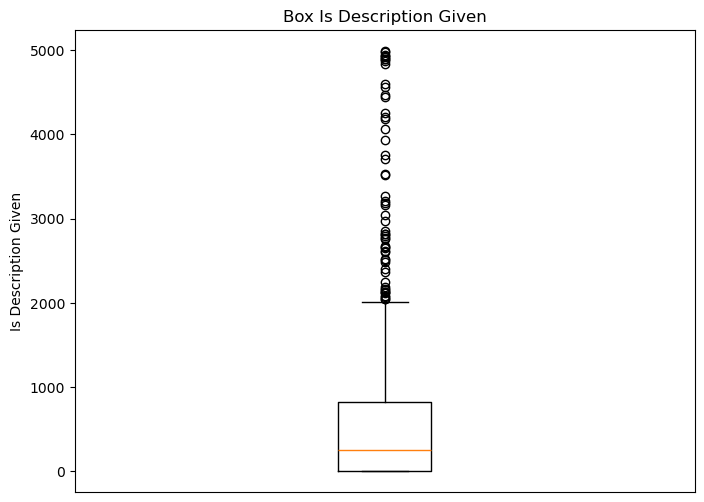

In [18]:
plt.figure(figsize = (8, 6))
plt.boxplot(df_local['Is_Description_Given'].dropna())
plt.title('Box Is Description Given')
plt.xticks([]);
plt.ylabel('Is Description Given');

In [19]:
ss = ScaleStatistics(df_local, ['Duration_Of_Video'],
                    normality_test = True)


SCALE STATISTICS SUMMARY
------------------



,N,mode,median,mean,25%,75%,interquart. range,interquart. range (norm.),min,max,range,std,var,entropy coef.,quality var.
Duration_Of_Video,904.000,60.000,102.500,788.027,40.000,791.250,751.250,0.034,4.000,21819.000,21815.000,1792.779,3214057.691,0.920,0.995



NORMALITY TESTS
------------------



,statistic,p-value
Duration_Of_Video,0.331,0.000


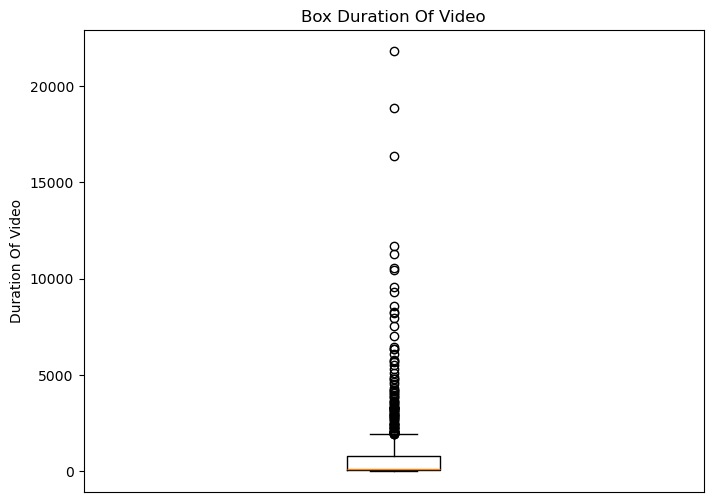

In [20]:
plt.figure(figsize = (8, 6))
plt.boxplot(df_local['Duration_Of_Video'].dropna())
plt.title('Box Duration Of Video')
plt.xticks([]);
plt.ylabel('Duration Of Video');

In [21]:
stats = df_local[['statistics.viewCount', 'statistics.likeCount', 'statistics.commentCount', 'Is_Description_Given']].describe()
stats

,statistics.viewCount,statistics.likeCount,statistics.commentCount,Is_Description_Given
count,9.040000e+02,875.000000,877.000000,904.000000
mean,9.180992e+04,2837.469714,195.651083,597.304204
std,5.679033e+05,15179.189811,755.576205,890.661277
min,0.000000e+00,0.000000,0.000000,0.000000
25%,2.197500e+02,5.000000,0.000000,0.000000
50%,1.584000e+03,28.000000,2.000000,252.000000
75%,1.003225e+04,342.500000,48.000000,817.000000
max,1.047056e+07,336689.000000,8365.000000,4991.000000


In [22]:
corr = Correlation(df_local[['statistics.viewCount', 'statistics.likeCount', 'statistics.commentCount', 'Is_Description_Given']])
corr.sort_correlations()


CORRELATION SUMMARY (PEARSON METHOD, 2-TAILED)
------------------


Note: Each empty index duplicates the previous one.
Maximum correlation is 0.908 (p-value 0.0) for variables statistics.viewCount and statistics.likeCount,
minimum correlation is 0.086 (p-value 0.012) for variables statistics.likeCount and Is_Description_Given.
Note: Each empty index duplicates the previous one.


,,Coefficient,p-value
statistics.likeCount,Is_Description_Given,0.085963,1.206876e-02
statistics.viewCount,Is_Description_Given,0.093535,6.291910e-03
statistics.commentCount,Is_Description_Given,0.236597,2.644052e-12
statistics.viewCount,statistics.commentCount,0.577502,6.124794e-77
statistics.likeCount,statistics.commentCount,0.636827,4.282738e-98
statistics.viewCount,statistics.likeCount,0.908094,9.881313e-324


Text(0, 0.5, 'likeCount')

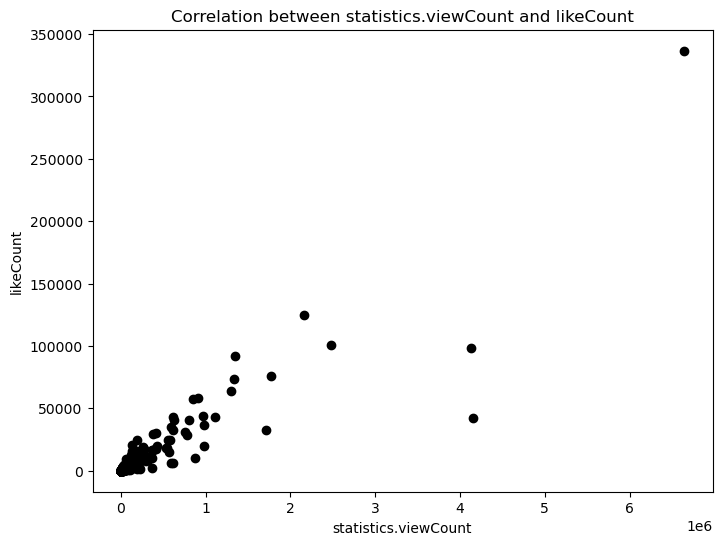

In [23]:
var = ['statistics.viewCount',
       'statistics.likeCount']
       
plt.figure(figsize = (8, 6))
plt.scatter(df_local[var[0]], df_local[var[-1]], c ='black')
plt.title(f"Correlation between {var[0]} and {var[-1].split('.')[-1]}")
plt.xlabel(f"{var[0]}")
plt.ylabel(f"{var[-1].split('.')[-1]}")

Text(0, 0.5, 'commentCount')

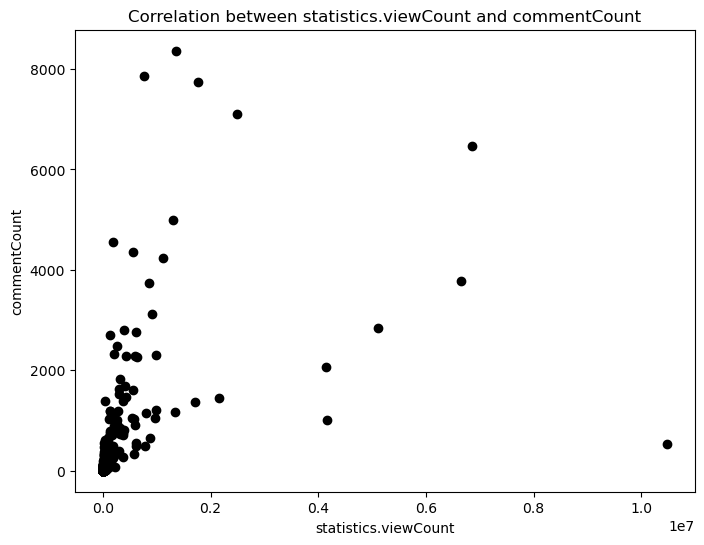

In [24]:
var = ['statistics.viewCount',
       'statistics.commentCount']
       
plt.figure(figsize = (8, 6))
plt.scatter(df_local[var[0]], df_local[var[-1]], c ='black')
plt.title(f"Correlation between {var[0]} and {var[-1].split('.')[-1]}")
plt.xlabel(f"{var[0]}")
plt.ylabel(f"{var[-1].split('.')[-1]}")

Text(0, 0.5, 'Is_Description_Given')

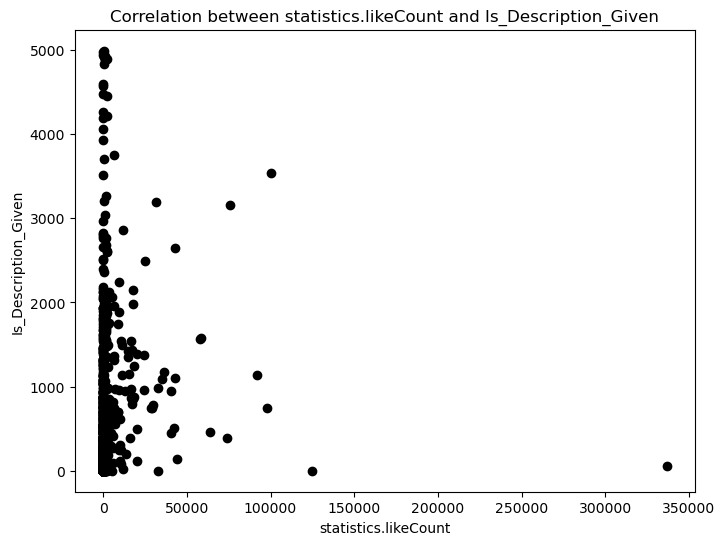

In [25]:
var = ['statistics.likeCount',
       'Is_Description_Given']
       
plt.figure(figsize = (8, 6))
plt.scatter(df_local[var[0]], df_local[var[-1]], c ='black')
plt.title(f"Correlation between {var[0]} and {var[-1].split('.')[-1]}")
plt.xlabel(f"{var[0]}")
plt.ylabel(f"{var[-1].split('.')[-1]}")

In [26]:
corr = Correlation(df_local[['statistics.viewCount', 'statistics.likeCount', 'Duration_Of_Video']])
corr.sort_correlations()


CORRELATION SUMMARY (PEARSON METHOD, 2-TAILED)
------------------


Note: Each empty index duplicates the previous one.
Maximum correlation is 0.908 (p-value 0.0) for variables statistics.viewCount and statistics.likeCount,
minimum correlation is 0.002 (p-value 0.952) for variables statistics.viewCount and Duration_Of_Video.
Note: Each empty index duplicates the previous one.


,,Coefficient,p-value
statistics.viewCount,Duration_Of_Video,0.002023,0.952358
statistics.likeCount,Duration_Of_Video,0.008057,0.811885
statistics.viewCount,statistics.likeCount,0.908205,0.000000


Text(0, 0.5, 'Duration_Of_Video')

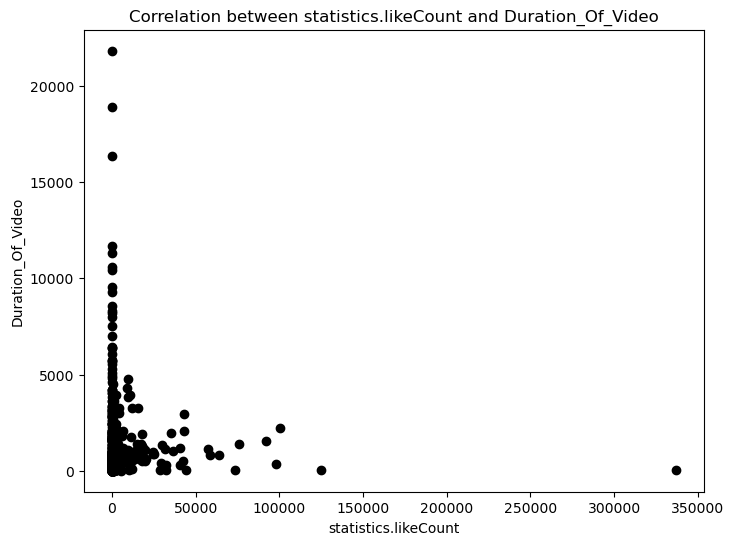

In [27]:
var = ['statistics.likeCount',
       'Duration_Of_Video']
       
plt.figure(figsize = (8, 6))
plt.scatter(df_local[var[0]], df_local[var[-1]], c ='black')
plt.title(f"Correlation between {var[0]} and {var[-1].split('.')[-1]}")
plt.xlabel(f"{var[0]}")
plt.ylabel(f"{var[-1].split('.')[-1]}")

# Preparing Data

In [28]:
part = "snippet,id,replies"
videoId = "mcrk0Jzsi5s" # for first loop we need id of a video you can take it from base we collected
amount = 100

In [31]:
start = time.time()
df_comments = pd.DataFrame()
df_video_new = df_video.head(50)

for video in df_video_new['id']:
    try:
        request = youtube.commentThreads().list(
            part = part,
            videoId = video,
            maxResults = amount)
        
        response = request.execute()
        
        add = pd.json_normalize(response['items'])
        df_comments = pd.concat([df_comments, add])
        
        print(f'Taking comments from video: {video}')
        
        i = 1
        while 'nextPageToken' in response.keys():
            request = youtube.commentThreads().list(
                part = part,
                videoId = video,
                maxResults = amount,
                pageToken = response['nextPageToken'])
            response = request.execute()

            add = pd.json_normalize(response['items'])
            df_comments = pd.concat([df_comments, add])

            print(f'Iteration {i}')
            i += 1
            
    except: 
        print(f"Error from video: {video}")
        
print(f'Time taken {int(time.time() - start)} sec.')

Taking comments from video: mcrk0Jzsi5s
Iteration 1
Iteration 2
Taking comments from video: Enrr6uPwy24
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Taking comments from video: TYo8weESz44
Iteration 1
Taking comments from video: DsWQpYf3Kbc
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Taking comments from video: dU9LKIfhIXY
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Taking comments from video: VjAGO_il9cI
Iteration 1
Taking comments from video: ctuOpCMIzDg
Iteration 1
Taki

In [32]:
df_comments = df_comments.drop_duplicates('id')
df_comments

,kind,etag,id,snippet.channelId,snippet.videoId,snippet.topLevelComment.kind,snippet.topLevelComment.etag,snippet.topLevelComment.id,snippet.topLevelComment.snippet.channelId,snippet.topLevelComment.snippet.videoId,...,snippet.topLevelComment.snippet.authorChannelId.value,snippet.topLevelComment.snippet.canRate,snippet.topLevelComment.snippet.viewerRating,snippet.topLevelComment.snippet.likeCount,snippet.topLevelComment.snippet.publishedAt,snippet.topLevelComment.snippet.updatedAt,snippet.canReply,snippet.totalReplyCount,snippet.isPublic,replies.comments
0,youtube#commentThread,2r5hAvgN07x_pF-mRsdu5YAESWM,UgwRNKOxZySoD7vcVed4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,youtube#comment,PQKEB_XXNIzM_NJBLNxtXTdwhi0,UgwRNKOxZySoD7vcVed4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,...,UCkcy210h-hv7E6j6P8CucUQ,True,none,7,2024-03-31T19:40:16Z,2024-03-31T19:40:16Z,True,3,True,"[{'kind': 'youtube#comment', 'etag': '7GOfdgjm..."
1,youtube#commentThread,4d98-y-zzk_Cisouz4xSsIcCQ8U,UgyaXVp0cAwXpz3y7PV4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,youtube#comment,cCADNYF4Ws-fpavw7YueagYgt3E,UgyaXVp0cAwXpz3y7PV4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,...,UC6HSNhG5lkJKWX-fJP9trSQ,True,none,0,2024-06-21T05:29:01Z,2024-06-21T05:29:01Z,True,0,True,NaN
2,youtube#commentThread,b8KV5w-a8ziGw111OdImLcDuNcg,UgzfgjrD0fdgv8EhULJ4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,youtube#comment,WrqO7YVuLBt6LyBQUMPEUm5_RDQ,UgzfgjrD0fdgv8EhULJ4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,...,UCCeMCjnwZC7Nc3nJxuaiTAQ,True,none,0,2024-06-21T03:09:03Z,2024-06-21T03:09:03Z,True,0,True,NaN
3,youtube#commentThread,cVBFdlZBByfCbKK-73CEbH9WipM,Ugxadcn5v75Nc_Xj9QR4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,youtube#comment,tltQfPqFTsu8kbtUDdqSA9-sRA0,Ugxadcn5v75Nc_Xj9QR4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,...,UCttK88GdurfL0t3z6Py4sZg,True,none,0,2024-06-20T05:32:04Z,2024-06-20T05:32:04Z,True,0,True,NaN
4,youtube#commentThread,ZPN5sSOHBL_kTS2xj6FuqmUczOg,UgwTm8ddG-Eioc2vzE14AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,youtube#comment,NNch8s3OPErPIPyvmHE_6IDa7-Q,UgwTm8ddG-Eioc2vzE14AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,...,UCykWuWyRdHiTIHDz5_flSEA,True,none,0,2024-06-17T19:37:34Z,2024-06-17T19:37:34Z,True,0,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,youtube#commentThread,zyf5kwVNof4h0nOTl2_75tw12lg,Ugzj6WUtC_QLZ2QErfZ4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,youtube#comment,NwIVOFWU2w3dDC3vEDhU2GcEQig,Ugzj6WUtC_QLZ2QErfZ4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,...,UCgl4rL2_6FH7mu6F1IsoZww,True,none,8,2022-06-21T12:24:49Z,2022-06-21T12:24:49Z,True,5,True,"[{'kind': 'youtube#comment', 'etag': 'MPHgtvzV..."
49,youtube#commentThread,Wmkm5bRNY0_vTo63gGLTC4tKVfc,UgwWT9KT6k9NtZ9CkXB4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,youtube#comment,zvxOysVRng0xB5o5tgdfjBD4Dxk,UgwWT9KT6k9NtZ9CkXB4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,...,UCmDEgQzNax4z8zcj98mhzQQ,True,none,18,2022-06-21T12:24:43Z,2022-06-21T12:24:43Z,True,4,True,"[{'kind': 'youtube#comment', 'etag': 'kzqJu7E9..."
50,youtube#commentThread,4N3WsruOa2ECIEWzWqrNbwh8Rxk,UgxcVjTkx-fPKdB_yCd4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,youtube#comment,aWNWHpNWD5fWdRvMgOL1rnHBAkU,UgxcVjTkx-fPKdB_yCd4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,...,UCclLCo06c7vzj34lkjlwzJQ,True,none,2,2022-06-21T12:24:34Z,2022-06-21T12:24:34Z,True,0,True,NaN
51,youtube#commentThread,u8EQlnHkLBAUo5scSUecAA190qY,UgyvJClAz0GFUhXFdrJ4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,youtube#comment,L4h7roUksggVUzFjyAydNhszEMY,UgyvJClAz0GFUhXFdrJ4AaABAg,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,...,UC_yrLpPtKhzBuxKoLN76GvA,True,none,332,2022-06-21T12:23:53Z,2022-06-21T12:23:53Z,True,32,True,"[{'kind': 'youtube#comment', 'etag': '_FFE2Kg4..."


In [34]:
print(df_comments.drop_duplicates('id')['snippet.totalReplyCount'].sum())
comments_replies_index = df_comments[df_comments['snippet.totalReplyCount'] > 0].index
print(comments_replies_index)
comments_replies = pd.json_normalize(df_comments['replies.comments'][comments_replies_index[0]])

34024
Index([ 0, 12, 17, 21, 25, 29, 32, 43, 49, 54,
       ...
       41, 42, 43, 45, 46, 47, 48, 49, 51, 52],
      dtype='int64', length=7274)


In [35]:
df_comments.loc[comments_replies_index[0], 'Difference'] = df_comments['snippet.totalReplyCount'][comments_replies_index[0]] - len(comments_replies)
df_comments.index = range (1, len(df_comments)+1)
comments_replies_index = df_comments[df_comments['snippet.totalReplyCount'] > 0].index
all_rep_comments = pd.DataFrame()

n = 1
start = time.time()
for i in comments_replies_index:
    df_comments.loc[i, 'Difference'] = df_comments['snippet.totalReplyCount'][i] - len(pd.json_normalize(df_comments['replies.comments'][i]))
    df_add = pd.json_normalize(df_comments['replies.comments'][i])
    all_rep_comments = pd.concat([all_rep_comments, df_add])
    
    n += 1 

print(f'All iterations: {n} For {time.time() - start} secs.')
all_rep_comments

Iteration № 1
Iteration № 2
Iteration № 3
Iteration № 4
Iteration № 5
Iteration № 6
Iteration № 7
Iteration № 8
Iteration № 9
Iteration № 10
Iteration № 11
Iteration № 12
Iteration № 13
Iteration № 14
Iteration № 15
Iteration № 16
Iteration № 17
Iteration № 18
Iteration № 19
Iteration № 20
Iteration № 21
Iteration № 22
Iteration № 23
Iteration № 24
Iteration № 25
Iteration № 26
Iteration № 27
Iteration № 28
Iteration № 29
Iteration № 30
Iteration № 31
Iteration № 32
Iteration № 33
Iteration № 34
Iteration № 35
Iteration № 36
Iteration № 37
Iteration № 38
Iteration № 39
Iteration № 40
Iteration № 41
Iteration № 42
Iteration № 43
Iteration № 44
Iteration № 45
Iteration № 46
Iteration № 47
Iteration № 48
Iteration № 49
Iteration № 50
Iteration № 51
Iteration № 52
Iteration № 53
Iteration № 54
Iteration № 55
Iteration № 56
Iteration № 57
Iteration № 58
Iteration № 59
Iteration № 60
Iteration № 61
Iteration № 62
Iteration № 63
Iteration № 64
Iteration № 65
Iteration № 66
Iteration № 67
Iter

Iteration № 734
Iteration № 735
Iteration № 736
Iteration № 737
Iteration № 738
Iteration № 739
Iteration № 740
Iteration № 741
Iteration № 742
Iteration № 743
Iteration № 744
Iteration № 745
Iteration № 746
Iteration № 747
Iteration № 748
Iteration № 749
Iteration № 750
Iteration № 751
Iteration № 752
Iteration № 753
Iteration № 754
Iteration № 755
Iteration № 756
Iteration № 757
Iteration № 758
Iteration № 759
Iteration № 760
Iteration № 761
Iteration № 762
Iteration № 763
Iteration № 764
Iteration № 765
Iteration № 766
Iteration № 767
Iteration № 768
Iteration № 769
Iteration № 770
Iteration № 771
Iteration № 772
Iteration № 773
Iteration № 774
Iteration № 775
Iteration № 776
Iteration № 777
Iteration № 778
Iteration № 779
Iteration № 780
Iteration № 781
Iteration № 782
Iteration № 783
Iteration № 784
Iteration № 785
Iteration № 786
Iteration № 787
Iteration № 788
Iteration № 789
Iteration № 790
Iteration № 791
Iteration № 792
Iteration № 793
Iteration № 794
Iteration № 795
Iteratio

Iteration № 1409
Iteration № 1410
Iteration № 1411
Iteration № 1412
Iteration № 1413
Iteration № 1414
Iteration № 1415
Iteration № 1416
Iteration № 1417
Iteration № 1418
Iteration № 1419
Iteration № 1420
Iteration № 1421
Iteration № 1422
Iteration № 1423
Iteration № 1424
Iteration № 1425
Iteration № 1426
Iteration № 1427
Iteration № 1428
Iteration № 1429
Iteration № 1430
Iteration № 1431
Iteration № 1432
Iteration № 1433
Iteration № 1434
Iteration № 1435
Iteration № 1436
Iteration № 1437
Iteration № 1438
Iteration № 1439
Iteration № 1440
Iteration № 1441
Iteration № 1442
Iteration № 1443
Iteration № 1444
Iteration № 1445
Iteration № 1446
Iteration № 1447
Iteration № 1448
Iteration № 1449
Iteration № 1450
Iteration № 1451
Iteration № 1452
Iteration № 1453
Iteration № 1454
Iteration № 1455
Iteration № 1456
Iteration № 1457
Iteration № 1458
Iteration № 1459
Iteration № 1460
Iteration № 1461
Iteration № 1462
Iteration № 1463
Iteration № 1464
Iteration № 1465
Iteration № 1466
Iteration № 14

Iteration № 2009
Iteration № 2010
Iteration № 2011
Iteration № 2012
Iteration № 2013
Iteration № 2014
Iteration № 2015
Iteration № 2016
Iteration № 2017
Iteration № 2018
Iteration № 2019
Iteration № 2020
Iteration № 2021
Iteration № 2022
Iteration № 2023
Iteration № 2024
Iteration № 2025
Iteration № 2026
Iteration № 2027
Iteration № 2028
Iteration № 2029
Iteration № 2030
Iteration № 2031
Iteration № 2032
Iteration № 2033
Iteration № 2034
Iteration № 2035
Iteration № 2036
Iteration № 2037
Iteration № 2038
Iteration № 2039
Iteration № 2040
Iteration № 2041
Iteration № 2042
Iteration № 2043
Iteration № 2044
Iteration № 2045
Iteration № 2046
Iteration № 2047
Iteration № 2048
Iteration № 2049
Iteration № 2050
Iteration № 2051
Iteration № 2052
Iteration № 2053
Iteration № 2054
Iteration № 2055
Iteration № 2056
Iteration № 2057
Iteration № 2058
Iteration № 2059
Iteration № 2060
Iteration № 2061
Iteration № 2062
Iteration № 2063
Iteration № 2064
Iteration № 2065
Iteration № 2066
Iteration № 20

Iteration № 2545
Iteration № 2546
Iteration № 2547
Iteration № 2548
Iteration № 2549
Iteration № 2550
Iteration № 2551
Iteration № 2552
Iteration № 2553
Iteration № 2554
Iteration № 2555
Iteration № 2556
Iteration № 2557
Iteration № 2558
Iteration № 2559
Iteration № 2560
Iteration № 2561
Iteration № 2562
Iteration № 2563
Iteration № 2564
Iteration № 2565
Iteration № 2566
Iteration № 2567
Iteration № 2568
Iteration № 2569
Iteration № 2570
Iteration № 2571
Iteration № 2572
Iteration № 2573
Iteration № 2574
Iteration № 2575
Iteration № 2576
Iteration № 2577
Iteration № 2578
Iteration № 2579
Iteration № 2580
Iteration № 2581
Iteration № 2582
Iteration № 2583
Iteration № 2584
Iteration № 2585
Iteration № 2586
Iteration № 2587
Iteration № 2588
Iteration № 2589
Iteration № 2590
Iteration № 2591
Iteration № 2592
Iteration № 2593
Iteration № 2594
Iteration № 2595
Iteration № 2596
Iteration № 2597
Iteration № 2598
Iteration № 2599
Iteration № 2600
Iteration № 2601
Iteration № 2602
Iteration № 26

Iteration № 3234
Iteration № 3235
Iteration № 3236
Iteration № 3237
Iteration № 3238
Iteration № 3239
Iteration № 3240
Iteration № 3241
Iteration № 3242
Iteration № 3243
Iteration № 3244
Iteration № 3245
Iteration № 3246
Iteration № 3247
Iteration № 3248
Iteration № 3249
Iteration № 3250
Iteration № 3251
Iteration № 3252
Iteration № 3253
Iteration № 3254
Iteration № 3255
Iteration № 3256
Iteration № 3257
Iteration № 3258
Iteration № 3259
Iteration № 3260
Iteration № 3261
Iteration № 3262
Iteration № 3263
Iteration № 3264
Iteration № 3265
Iteration № 3266
Iteration № 3267
Iteration № 3268
Iteration № 3269
Iteration № 3270
Iteration № 3271
Iteration № 3272
Iteration № 3273
Iteration № 3274
Iteration № 3275
Iteration № 3276
Iteration № 3277
Iteration № 3278
Iteration № 3279
Iteration № 3280
Iteration № 3281
Iteration № 3282
Iteration № 3283
Iteration № 3284
Iteration № 3285
Iteration № 3286
Iteration № 3287
Iteration № 3288
Iteration № 3289
Iteration № 3290
Iteration № 3291
Iteration № 32

Iteration № 3836
Iteration № 3837
Iteration № 3838
Iteration № 3839
Iteration № 3840
Iteration № 3841
Iteration № 3842
Iteration № 3843
Iteration № 3844
Iteration № 3845
Iteration № 3846
Iteration № 3847
Iteration № 3848
Iteration № 3849
Iteration № 3850
Iteration № 3851
Iteration № 3852
Iteration № 3853
Iteration № 3854
Iteration № 3855
Iteration № 3856
Iteration № 3857
Iteration № 3858
Iteration № 3859
Iteration № 3860
Iteration № 3861
Iteration № 3862
Iteration № 3863
Iteration № 3864
Iteration № 3865
Iteration № 3866
Iteration № 3867
Iteration № 3868
Iteration № 3869
Iteration № 3870
Iteration № 3871
Iteration № 3872
Iteration № 3873
Iteration № 3874
Iteration № 3875
Iteration № 3876
Iteration № 3877
Iteration № 3878
Iteration № 3879
Iteration № 3880
Iteration № 3881
Iteration № 3882
Iteration № 3883
Iteration № 3884
Iteration № 3885
Iteration № 3886
Iteration № 3887
Iteration № 3888
Iteration № 3889
Iteration № 3890
Iteration № 3891
Iteration № 3892
Iteration № 3893
Iteration № 38

Iteration № 4412
Iteration № 4413
Iteration № 4414
Iteration № 4415
Iteration № 4416
Iteration № 4417
Iteration № 4418
Iteration № 4419
Iteration № 4420
Iteration № 4421
Iteration № 4422
Iteration № 4423
Iteration № 4424
Iteration № 4425
Iteration № 4426
Iteration № 4427
Iteration № 4428
Iteration № 4429
Iteration № 4430
Iteration № 4431
Iteration № 4432
Iteration № 4433
Iteration № 4434
Iteration № 4435
Iteration № 4436
Iteration № 4437
Iteration № 4438
Iteration № 4439
Iteration № 4440
Iteration № 4441
Iteration № 4442
Iteration № 4443
Iteration № 4444
Iteration № 4445
Iteration № 4446
Iteration № 4447
Iteration № 4448
Iteration № 4449
Iteration № 4450
Iteration № 4451
Iteration № 4452
Iteration № 4453
Iteration № 4454
Iteration № 4455
Iteration № 4456
Iteration № 4457
Iteration № 4458
Iteration № 4459
Iteration № 4460
Iteration № 4461
Iteration № 4462
Iteration № 4463
Iteration № 4464
Iteration № 4465
Iteration № 4466
Iteration № 4467
Iteration № 4468
Iteration № 4469
Iteration № 44

Iteration № 4950
Iteration № 4951
Iteration № 4952
Iteration № 4953
Iteration № 4954
Iteration № 4955
Iteration № 4956
Iteration № 4957
Iteration № 4958
Iteration № 4959
Iteration № 4960
Iteration № 4961
Iteration № 4962
Iteration № 4963
Iteration № 4964
Iteration № 4965
Iteration № 4966
Iteration № 4967
Iteration № 4968
Iteration № 4969
Iteration № 4970
Iteration № 4971
Iteration № 4972
Iteration № 4973
Iteration № 4974
Iteration № 4975
Iteration № 4976
Iteration № 4977
Iteration № 4978
Iteration № 4979
Iteration № 4980
Iteration № 4981
Iteration № 4982
Iteration № 4983
Iteration № 4984
Iteration № 4985
Iteration № 4986
Iteration № 4987
Iteration № 4988
Iteration № 4989
Iteration № 4990
Iteration № 4991
Iteration № 4992
Iteration № 4993
Iteration № 4994
Iteration № 4995
Iteration № 4996
Iteration № 4997
Iteration № 4998
Iteration № 4999
Iteration № 5000
Iteration № 5001
Iteration № 5002
Iteration № 5003
Iteration № 5004
Iteration № 5005
Iteration № 5006
Iteration № 5007
Iteration № 50

Iteration № 5443
Iteration № 5444
Iteration № 5445
Iteration № 5446
Iteration № 5447
Iteration № 5448
Iteration № 5449
Iteration № 5450
Iteration № 5451
Iteration № 5452
Iteration № 5453
Iteration № 5454
Iteration № 5455
Iteration № 5456
Iteration № 5457
Iteration № 5458
Iteration № 5459
Iteration № 5460
Iteration № 5461
Iteration № 5462
Iteration № 5463
Iteration № 5464
Iteration № 5465
Iteration № 5466
Iteration № 5467
Iteration № 5468
Iteration № 5469
Iteration № 5470
Iteration № 5471
Iteration № 5472
Iteration № 5473
Iteration № 5474
Iteration № 5475
Iteration № 5476
Iteration № 5477
Iteration № 5478
Iteration № 5479
Iteration № 5480
Iteration № 5481
Iteration № 5482
Iteration № 5483
Iteration № 5484
Iteration № 5485
Iteration № 5486
Iteration № 5487
Iteration № 5488
Iteration № 5489
Iteration № 5490
Iteration № 5491
Iteration № 5492
Iteration № 5493
Iteration № 5494
Iteration № 5495
Iteration № 5496
Iteration № 5497
Iteration № 5498
Iteration № 5499
Iteration № 5500
Iteration № 55

Iteration № 5997
Iteration № 5998
Iteration № 5999
Iteration № 6000
Iteration № 6001
Iteration № 6002
Iteration № 6003
Iteration № 6004
Iteration № 6005
Iteration № 6006
Iteration № 6007
Iteration № 6008
Iteration № 6009
Iteration № 6010
Iteration № 6011
Iteration № 6012
Iteration № 6013
Iteration № 6014
Iteration № 6015
Iteration № 6016
Iteration № 6017
Iteration № 6018
Iteration № 6019
Iteration № 6020
Iteration № 6021
Iteration № 6022
Iteration № 6023
Iteration № 6024
Iteration № 6025
Iteration № 6026
Iteration № 6027
Iteration № 6028
Iteration № 6029
Iteration № 6030
Iteration № 6031
Iteration № 6032
Iteration № 6033
Iteration № 6034
Iteration № 6035
Iteration № 6036
Iteration № 6037
Iteration № 6038
Iteration № 6039
Iteration № 6040
Iteration № 6041
Iteration № 6042
Iteration № 6043
Iteration № 6044
Iteration № 6045
Iteration № 6046
Iteration № 6047
Iteration № 6048
Iteration № 6049
Iteration № 6050
Iteration № 6051
Iteration № 6052
Iteration № 6053
Iteration № 6054
Iteration № 60

Iteration № 6516
Iteration № 6517
Iteration № 6518
Iteration № 6519
Iteration № 6520
Iteration № 6521
Iteration № 6522
Iteration № 6523
Iteration № 6524
Iteration № 6525
Iteration № 6526
Iteration № 6527
Iteration № 6528
Iteration № 6529
Iteration № 6530
Iteration № 6531
Iteration № 6532
Iteration № 6533
Iteration № 6534
Iteration № 6535
Iteration № 6536
Iteration № 6537
Iteration № 6538
Iteration № 6539
Iteration № 6540
Iteration № 6541
Iteration № 6542
Iteration № 6543
Iteration № 6544
Iteration № 6545
Iteration № 6546
Iteration № 6547
Iteration № 6548
Iteration № 6549
Iteration № 6550
Iteration № 6551
Iteration № 6552
Iteration № 6553
Iteration № 6554
Iteration № 6555
Iteration № 6556
Iteration № 6557
Iteration № 6558
Iteration № 6559
Iteration № 6560
Iteration № 6561
Iteration № 6562
Iteration № 6563
Iteration № 6564
Iteration № 6565
Iteration № 6566
Iteration № 6567
Iteration № 6568
Iteration № 6569
Iteration № 6570
Iteration № 6571
Iteration № 6572
Iteration № 6573
Iteration № 65

Iteration № 7021
Iteration № 7022
Iteration № 7023
Iteration № 7024
Iteration № 7025
Iteration № 7026
Iteration № 7027
Iteration № 7028
Iteration № 7029
Iteration № 7030
Iteration № 7031
Iteration № 7032
Iteration № 7033
Iteration № 7034
Iteration № 7035
Iteration № 7036
Iteration № 7037
Iteration № 7038
Iteration № 7039
Iteration № 7040
Iteration № 7041
Iteration № 7042
Iteration № 7043
Iteration № 7044
Iteration № 7045
Iteration № 7046
Iteration № 7047
Iteration № 7048
Iteration № 7049
Iteration № 7050
Iteration № 7051
Iteration № 7052
Iteration № 7053
Iteration № 7054
Iteration № 7055
Iteration № 7056
Iteration № 7057
Iteration № 7058
Iteration № 7059
Iteration № 7060
Iteration № 7061
Iteration № 7062
Iteration № 7063
Iteration № 7064
Iteration № 7065
Iteration № 7066
Iteration № 7067
Iteration № 7068
Iteration № 7069
Iteration № 7070
Iteration № 7071
Iteration № 7072
Iteration № 7073
Iteration № 7074
Iteration № 7075
Iteration № 7076
Iteration № 7077
Iteration № 7078
Iteration № 70

,kind,etag,id,snippet.channelId,snippet.videoId,snippet.textDisplay,snippet.textOriginal,snippet.parentId,snippet.authorDisplayName,snippet.authorProfileImageUrl,snippet.authorChannelUrl,snippet.authorChannelId.value,snippet.canRate,snippet.viewerRating,snippet.likeCount,snippet.publishedAt,snippet.updatedAt
0,youtube#comment,7GOfdgjmgeOdXqOxOT4-sQOBJBY,UgwRNKOxZySoD7vcVed4AaABAg.A1ehy9MUwLgA1etBDhCvv4,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,Ты чего это так дерзко?,Ты чего это так дерзко?,UgwRNKOxZySoD7vcVed4AaABAg,@user-kj4tq3hn1p,https://yt3.ggpht.com/ytc/AIdro_nO5_AnrR5wC3yi...,http://www.youtube.com/@user-kj4tq3hn1p,UCWpcVs0vyKT49xZzlqhCPxA,True,none,0,2024-03-31T21:18:18Z,2024-03-31T21:18:18Z
1,youtube#comment,NvHdvwSebqMFirKFskAXDYVAX4w,UgwRNKOxZySoD7vcVed4AaABAg.A1ehy9MUwLgA1fuvryI-Ea,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,жду вижос про самолёты!,жду вижос про самолёты!,UgwRNKOxZySoD7vcVed4AaABAg,@Maks-vo3uo,https://yt3.ggpht.com/ytc/AIdro_kIQd925lZn3kNv...,http://www.youtube.com/@Maks-vo3uo,UCrKlzohQ2tDNqMiekXEdu8A,True,none,0,2024-04-01T06:52:47Z,2024-04-01T06:52:47Z
2,youtube#comment,QmqOf5d8EdZFSnvAlC_VQ4kf4Hk,UgwRNKOxZySoD7vcVed4AaABAg.A1ehy9MUwLgA1i3hHBSXA2,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,@@user-kj4tq3hn1p Это один из тех кто хочет вс...,@@user-kj4tq3hn1p Это один из тех кто хочет вс...,UgwRNKOxZySoD7vcVed4AaABAg,@aviktorrusso657,https://yt3.ggpht.com/ytc/AIdro_lcNqmnOgt3YywG...,http://www.youtube.com/@aviktorrusso657,UCQLynzvnhqYGsqNJYxibTow,True,none,0,2024-04-02T02:56:40Z,2024-04-02T02:56:40Z
0,youtube#comment,PYos471z8Eh0_dJmJaB_bzWC1qg,Ugx0UNhEkQUObGKF-Y54AaABAg.A4HQUWeX5E_A4iPY696kB2,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,Благоларя враденому супосату у наших нет выбор...,Благоларя враденому супосату у наших нет выбор...,Ugx0UNhEkQUObGKF-Y54AaABAg,@user-kg2xd9qw4f,https://yt3.ggpht.com/ytc/AIdro_lhEravwhfJG4jo...,http://www.youtube.com/@user-kg2xd9qw4f,UCpHEblGvvsxQwHtqWQfWGbw,True,none,0,2024-06-15T19:41:41Z,2024-06-15T19:41:41Z
1,youtube#comment,WGjrD5-CA-2iC7LC2dtY-1HfurE,Ugx0UNhEkQUObGKF-Y54AaABAg.A4HQUWeX5E_A4igDrFMnmo,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,@@user-kg2xd9qw4f да кто там будет строить.Раш...,@@user-kg2xd9qw4f да кто там будет строить.Раш...,Ugx0UNhEkQUObGKF-Y54AaABAg,@kamaz-xd6eh,https://yt3.ggpht.com/E-JOQsJ4fuaqgDRkTbKPUCxG...,http://www.youtube.com/@kamaz-xd6eh,UCTiDOCRDL_NOoM-SfPGX17Q,True,none,0,2024-06-15T22:16:13Z,2024-06-15T22:16:13Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,youtube#comment,1rgK64bZm0kMoqZiOJ4h6loKJmo,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXpgITdk0D,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,"@@cyber_cat. Танки? Да нет, вроде советские в ...","@@cyber_cat. Танки? Да нет, вроде советские в ...",UgyvJClAz0GFUhXFdrJ4AaABAg,@Pakoviy_Opuxol,https://yt3.ggpht.com/dHDRfNOyNtEWWSNyZEIuZAyY...,http://www.youtube.com/@Pakoviy_Opuxol,UC_yrLpPtKhzBuxKoLN76GvA,True,none,20,2022-06-21T12:37:33Z,2022-06-21T12:37:33Z
3,youtube#comment,qzo-OtVtmdpUgMBvzu7R3d0cnkM,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXq9wq05RF,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,@@Pakoviy_Opuxol т90 советский разве?,@@Pakoviy_Opuxol т90 советский разве?,UgyvJClAz0GFUhXFdrJ4AaABAg,@user-bn1bk4cn8b,https://yt3.ggpht.com/TDwnYtKiZTsb3daTbInSJsla...,http://www.youtube.com/@user-bn1bk4cn8b,UCnU-h5VeSnfq0eCS10NP8dQ,True,none,2,2022-06-21T12:41:44Z,2022-06-21T12:44:50Z
4,youtube#comment,231vCNqaiIoeeENkC2UtkHkRKmk,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXrCv8vrHm,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,"@bluetooth Фейк? Интересно вот, когда Матвиенк...","@bluetooth Фейк? Интересно вот, когда Матвиенк...",UgyvJClAz0GFUhXFdrJ4AaABAg,@Pakoviy_Opuxol,https://yt3.ggpht.com/dHDRfNOyNtEWWSNyZEIuZAyY...,http://www.youtube.com/@Pakoviy_Opuxol,UC_yrLpPtKhzBuxKoLN76GvA,True,none,11,2022-06-21T12:50:53Z,2023-11-16T04:16:58Z
0,youtube#comment,si9ywmRNnjFaPuHGI41AqYqXACk,UgxiSEGqt4Jt7xd0-Al4AaABAg.9cXo5uYjIqw9cXoGCwe6PV,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,Нет),Нет),UgxiSEGqt4Jt7xd0-Al4AaABAg,@Pakoviy_Opuxol,http

In [36]:
comments_replies = df_comments.copy()
comments_replies = comments_replies.drop(['snippet.topLevelComment.kind', 
                                          'snippet.topLevelComment.etag', 
                                          'snippet.topLevelComment.id', 
                                          'snippet.topLevelComment.snippet.channelId',
                                          'snippet.topLevelComment.snippet.videoId'], axis=1)

In [37]:
mutual = []

for i in comments_replies.columns:
    if 'snippet.topLevelComment.' in i:
        i = i.replace('snippet.topLevelComment.', '')
    mutual.append(i)
comments_replies.columns = mutual 
comments_replies

mututal = []

for i in comments_replies.columns:
    if i in all_rep_comments.columns:
        mutual.append(i)

all_rep_comments.loc[:, 'snippet.totalReplyCount'] = 0
all_rep_comments.loc[:, 'Difference'] = 0

mutual = []

for column in comments_replies.columns:
    if column in all_rep_comments.columns:
        mutual.append(column)
mutual
comments_replies = comments_replies[mutual]
all_rep_comments = all_rep_comments[mutual]

In [38]:
comments_replies = pd.concat([comments_replies, all_rep_comments])
comments_replies # our full base of comments

,kind,etag,id,snippet.channelId,snippet.videoId,snippet.textDisplay,snippet.textOriginal,snippet.authorDisplayName,snippet.authorProfileImageUrl,snippet.authorChannelUrl,snippet.authorChannelId.value,snippet.canRate,snippet.viewerRating,snippet.likeCount,snippet.publishedAt,snippet.updatedAt,snippet.totalReplyCount,Difference
1,youtube#commentThread,2r5hAvgN07x_pF-mRsdu5YAESWM,UgwRNKOxZySoD7vcVed4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,"На Телегу подпишись <a href=""https://t.me/thea...",На Телегу подпишись https://t.me/thearseny,@diamagnetic,https://yt3.ggpht.com/KyZIcgyalEK5qBLucsbu7LM0...,http://www.youtube.com/@diamagnetic,UCkcy210h-hv7E6j6P8CucUQ,True,none,7,2024-03-31T19:40:16Z,2024-03-31T19:40:16Z,3,0.0
2,youtube#commentThread,4d98-y-zzk_Cisouz4xSsIcCQ8U,UgyaXVp0cAwXpz3y7PV4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,"Шутки как на Одесском рынке, крайне вульгарные...","Шутки как на Одесском рынке, крайне вульгарные...",@dimkot1444,https://yt3.ggpht.com/ytc/AIdro_kXf_5nGjgC8_oS...,http://www.youtube.com/@dimkot1444,UC6HSNhG5lkJKWX-fJP9trSQ,True,none,0,2024-06-21T05:29:01Z,2024-06-21T05:29:01Z,0,NaN
3,youtube#commentThread,b8KV5w-a8ziGw111OdImLcDuNcg,UgzfgjrD0fdgv8EhULJ4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,Привет с авиационного завода🖐,Привет с авиационного завода🖐,@Elki_palki_,https://yt3.ggpht.com/11sSCEijZMnZs_L7KEp5D7WV...,http://www.youtube.com/@Elki_palki_,UCCeMCjnwZC7Nc3nJxuaiTAQ,True,none,0,2024-06-21T03:09:03Z,2024-06-21T03:09:03Z,0,NaN
4,youtube#commentThread,cVBFdlZBByfCbKK-73CEbH9WipM,Ugxadcn5v75Nc_Xj9QR4AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,Жду видео про самалётик!!,Жду видео про самалётик!!,@Ivanys_odyvanys,https://yt3.ggpht.com/ytc/AIdro_nE9RYXKV4ECT75...,http://www.youtube.com/@Ivanys_odyvanys,UCttK88GdurfL0t3z6Py4sZg,True,none,0,2024-06-20T05:32:04Z,2024-06-20T05:32:04Z,0,NaN
5,youtube#commentThread,ZPN5sSOHBL_kTS2xj6FuqmUczOg,UgwTm8ddG-Eioc2vzE14AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,Как классно получилось на превьювке флаг ДНР и...,Как классно получилось на превьювке флаг ДНР и...,@vadimfomin1870,https://yt3.ggpht.com/ytc/AIdro_nxtVKemfTFwZFC...,http://www.youtube.com/@vadimfomin1870,UCykWuWyRdHiTIHDz5_flSEA,True,none,0,2024-06-17T19:37:34Z,2024-06-17T19:37:34Z,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,youtube#comment,1rgK64bZm0kMoqZiOJ4h6loKJmo,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXpgITdk0D,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,"@@cyber_cat. Танки? Да нет, вроде советские в ...","@@cyber_cat. Танки? Да нет, вроде советские в ...",@Pakoviy_Opuxol,https://yt3.ggpht.com/dHDRfNOyNtEWWSNyZEIuZAyY...,http://www.youtube.com/@Pakoviy_Opuxol,UC_yrLpPtKhzBuxKoLN76GvA,True,none,20,2022-06-21T12:37:33Z,2022-06-21T12:37:33Z,0,0.0
3,youtube#comment,qzo-OtVtmdpUgMBvzu7R3d0cnkM,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXq9wq05RF,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,@@Pakoviy_Opuxol т90 советский разве?,@@Pakoviy_Opuxol т90 советский разве?,@user-bn1bk4cn8b,https://yt3.ggpht.com/TDwnYtKiZTsb3daTbInSJsla...,http://www.youtube.com/@user-bn1bk4cn8b,UCnU-h5VeSnfq0eCS10NP8dQ,True,none,2,2022-06-21T12:41:44Z,2022-06-21T12:44:50Z,0,0.0
4,youtube#comment,231vCNqaiIoeeENkC2UtkHkRKmk,UgyvJClAz0GFUhXFdrJ4AaABAg.9cXo792F6yQ9cXrCv8vrHm,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,"@bluetooth Фейк? Интересно вот, когда Матвиенк...","@bluetooth Фейк? Интересно вот, когда Матвиенк...",@Pakoviy_Opuxol,https://yt3.ggpht.com/dHDRfNOyNtEWWSNyZEIuZAyY...,http://www.youtube.com/@Pakoviy_Opuxol,UC_yrLpPtKhzBuxKoLN76GvA,True,none,11,2022-06-21T12:50:53Z,2023-11-16T04:16:58Z,0,0.0
0,youtube#comment,si9ywmRNnjFaPuHGI41AqYqXACk,UgxiSEGqt4Jt7xd0-Al4AaABAg.9cXo5uYjIqw9cXoGCwe6PV,UCgDiQ16ybF4Ov9aEg6kkYGg,guPfgFL5eu0,Нет),Нет),@Pakoviy_Opuxol,https://yt3.ggpht.com/dHDRfNOyNtEWWSNyZEIuZAyY...,http://www.youtube.com/@Pakoviy_Opuxol,UC_yrLpPtKhzBuxKoLN76GvA,True,none,0,2022-06-21T12:25:07Z,2022-06-21T12:25:07Z,0,0.0


# Let's perform Sentiment analysis

In [ ]:
# comments_replies.to_excel(f'База_Комментариев.xlsx')
# you can save it now and use later

In [39]:
comments_replies['len_count'] = comments_replies['snippet.textOriginal'].apply(lambda x: len(x.split()))
filtered_df = comments_replies[(comments_replies['len_count'] >= 5) & (comments_replies['len_count'] <= 30)]
filtered_df.drop(columns=['len_count'], inplace=True)

/var/folders/6j/76j_v0v96c7cg796p_fkhy200000gn/T/ipykernel_45917/3055271316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['len_count'], inplace=True)


In [40]:
filtered_df['snippet.publishedAt'] = filtered_df['snippet.publishedAt'].apply(lambda yyyy: int(yyyy[:4]))
comments_replies_work = filtered_df[filtered_df['snippet.publishedAt'] > 2021]
comments_replies_work['snippet.publishedAt'].unique()

/var/folders/6j/76j_v0v96c7cg796p_fkhy200000gn/T/ipykernel_45917/1282779373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['snippet.publishedAt'] = filtered_df['snippet.publishedAt'].apply(lambda yyyy: int(yyyy[:4]))


array([2024, 2023, 2022])

In [41]:
comments_replies_work = comments_replies_work.sample(n=5000, random_state=1)
comments_replies_work.index = range(1, len(comments_replies_work) + 1)
comments_replies_work

,kind,etag,id,snippet.channelId,snippet.videoId,snippet.textDisplay,snippet.textOriginal,snippet.authorDisplayName,snippet.authorProfileImageUrl,snippet.authorChannelUrl,snippet.authorChannelId.value,snippet.canRate,snippet.viewerRating,snippet.likeCount,snippet.publishedAt,snippet.updatedAt,snippet.totalReplyCount,Difference
1,youtube#commentThread,ig_2vIk2uyrnKUs-gkRaaifDwtM,UgyB3-JX57tFBRNE0Lx4AaABAg,UCUGfDbfRIx51kJGGHIFo8Rw,0gdCR1HrA_Y,Труд всей вашей команды особенно значим сегодня.,Труд всей вашей команды особенно значим сегодня.,@bigbitya6862,https://yt3.ggpht.com/ytc/AIdro_lZZ3DGadTo0Dqn...,http://www.youtube.com/@bigbitya6862,UCBTD89E6f57fjDss3OFs_bg,True,none,0,2022,2022-12-25T16:43:52Z,0,NaN
2,youtube#commentThread,M0TjKArs_IHDE4AlahhOhM7bDeM,UgxdXw08hqhgovAAhXp4AaABAg,UC101o-vQ2iOj9vr00JUlyKw,x9VteD_RFg0,Надо с родителей спросить где их детки ножки р...,Надо с родителей спросить где их детки ножки р...,@fridrich4769,https://yt3.ggpht.com/ytc/AIdro_nwfT50htsthWKb...,http://www.youtube.com/@fridrich4769,UC7wuWRXmzFoc-a799lc-Opg,True,none,1,2022,2022-08-07T12:14:02Z,0,NaN
3,youtube#commentThread,68-uc3TY-eaVg02fe-9PxX-OsHo,UgzZjBHCjhcHqk4LjqB4AaABAg,UC8qjk39Hk7i8i7VUNnWVVNQ,A07A2MN_fVM,С мамиксом всё в порядке) он снимал новогодние...,С мамиксом всё в порядке) он снимал новогодние...,@sexybrigadir7324,https://yt3.ggpht.com/ytc/AIdro_mPC0U7unulUkW4...,http://www.youtube.com/@sexybrigadir7324,UCrRoLUC50xF49fChQrpBtpg,True,none,0,2024,2024-02-09T14:20:23Z,0,NaN
4,youtube#commentThread,__gSlhNSZzaD-G3bKtei8vwpq-E,Ugw-qxglIEY8BpGwHqd4AaABAg,UCFKDcjx5ekaoMog_9zw82fA,0eeg1pvGjFc,Кола от Черноголовки лучше оригинала,Кола от Черноголовки лучше оригинала,@uliospento3574,https://yt3.ggpht.com/KvVJFBgPSVhWiUMPKjvZzhWh...,http://www.youtube.com/@uliospento3574,UCxdQNjkdzgpy8xG48AYWLfg,True,none,0,2022,2022-11-16T21:27:55Z,0,NaN
5,youtube#commentThread,CH4haIBdW6y5xGa1iEClog4l5zU,Ugwdp42JACVekVClwFN4AaABAg,UC101o-vQ2iOj9vr00JUlyKw,x9VteD_RFg0,"Зачем рускому ваньки бренды, лапти пусть вяжет...","Зачем рускому ваньки бренды, лапти пусть вяжет...",@andreylosev2018,https://yt3.ggpht.com/ytc/AIdro_nJqQ_sh5LmKJ9u...,http://www.youtube.com/@andreylosev2018,UCjRlLO5dK_KGkHbT8Kw2mWg,True,none,1,2022,2022-08-07T13:49:02Z,0,-406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,youtube#commentThread,fo3eudxZAPKVwqxC32yRYpJep9I,UgzbD9LAn3k6ayUnK0l4AaABAg,UCEf4_2dS16XL7G5wOgoLDDQ,b9gwXCGEEzw,"а наш гарант сам заявил, что интернет не смотр...","а наш гарант сам заявил, что интернет не смотр...",@glebivanoff6125,https://yt3.ggpht.com/ytc/AIdro_mJtKdSb2qmaKPL...,http://www.youtube.com/@glebivanoff6125,UCvLfuyk5DzMZtAKUv0WQmJA,True,none,0,2024,2024-02-29T03:43:23Z,0,NaN
4997,youtube#commentThread,dqpfrZ_JLPWBZohr_mFpBNi0nMM,UgyfF0DV6HDZ-OkdJ_14AaABAg,UCkcy210h-hv7E6j6P8CucUQ,mcrk0Jzsi5s,очень хочется про самолет услышать,очень хочется про самолет услышать,@user-lf5tz2pj2r,https://yt3.ggpht.com/ytc/AIdro_nqscWA0rKzAQhI...,http://www.youtube.com/@user-lf5tz2pj2r,UCq3WqyT8bChhsA6YV2liZlQ,True,none,0,2024,2024-04-03T11:46:25Z,0,NaN
4998,youtube#commentThread,sao2PZc80X1770cga83IqFhrm3g,UgxJXngFIJfB947PLSF4AaABAg,UC101o-vQ2iOj9vr00JUlyKw,oahrl7aXKvI,"Чувак сделал ролик, а ты кучерян.","Чувак сделал ролик, а ты кучерян.",@user-xn2pl3mm4e,https://yt3.ggpht.com/ytc/AIdro_kEy4N3JCAQcZi1...,http://www.youtube.com/@user-xn2pl3mm4e,UC9KOEGGlNiAokJ1_cuHJRXg,True,none,0,2023,2023-10-12T18:04:36Z,0,NaN
4999,youtube#comment,PmnPoQZaVu09aj0JRNyxQgTz30Q,UgyMEjql1tzYlD_mT9x4AaABAg.9eNiCOMVocw9eNj9myYu2g,UC101o-vQ2iOj9vr00JUlyKw,x9VteD_RFg0,О хосподя... как люська абдристович вам мозги ...,О хосподя... как люська абдристович вам мозги ...,@jkst2646,https://yt3.ggpht.com/ytc/AIdro_n2f1X64tHdgky3...,http://www.youtube.com/@jkst2646,UCZKwhXurihn2yU9u0_YlDeQ,True,none,1,2022,2022-08-06T07:30:56Z,0,0.0


In [42]:
start = time.time()
stopwords = stop_words.get_stop_words('russian')
mstem = pymystem3.Mystem()

def clean_and_process_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zа-я0-9 ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    lemmatized_text = ''.join(mstem.lemmatize(text))
    cleaned_text = ' '.join([word for word in lemmatized_text.split() if word not in stopwords])
    
    return cleaned_text

comments_replies_work['Frequency_analysis'] = comments_replies_work['snippet.textOriginal'].apply(clean_and_process_text)

end = time.time()

print(f'Time taken {int(end - start)} secs.')

Time taken 3 secs.


In [43]:
clean_comments = comments_replies_work[['snippet.textOriginal', 'Frequency_analysis']]
clean_comments

,snippet.textOriginal,Frequency analysis
1,Труд всей вашей команды особенно значим сегодня.,труд команда значимый
2,Надо с родителей спросить где их детки ножки р...,родитель спрашивать ребеночек ножка ручка поте...
3,С мамиксом всё в порядке) он снимал новогодние...,мамикс вс порядок снимать новогодний ролик
4,Кола от Черноголовки лучше оригинала,кол черноголовка оригинал
5,"Зачем рускому ваньки бренды, лапти пусть вяжет...",руский ванька бренд лапоть пусть вязать мда пи...
...,...,...
4996,"а наш гарант сам заявил, что интернет не смотр...",гарант заявлять интернет смотреть цифра узнавать
4997,очень хочется про самолет услышать,хотеться самолет услышать
4998,"Чувак сделал ролик, а ты кучерян.",чувак сделать ролик кучерянин
4999,О хосподя... как люська абдристович вам мозги ...,хосподя люська абдристович мозги делать отлично


In [44]:
count_vector = CountVectorizer().fit(clean_comments['Frequency_analysis'])
matrix = count_vector.transform(clean_comments['Frequency_analysis'])
matrix_df = pd.DataFrame(matrix.toarray(), columns=count_vector.get_feature_names_out(), index=clean_comments.index)

matrix_df

,00,000,00000000000000000000000,000к,00е,01,02,03,04,05,...,ярость,ярус,ясно,ясный,ят,яхрома,яхта,яшин,ящик,яя
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
matrix_df[:].sum().sort_values(ascending=False).head(30)

россия              362
страна              214
вс                  211
свой                209
кол                 178
делать              154
видео               139
импортозамещение    136
ещ                  134
хороший             133
user                133
самый               124
русский             121
говорить            119
ролик               117
понимать            112
работать            108
сделать             108
вообще              102
жить                 97
знать                96
путин                89
смотреть             85
давать               85
российский           84
китай                83
ничто                83
игра                 79
рф                   77
становиться          77
dtype: int64

In [47]:
matrix_df = pd.concat([clean_comments, matrix_df], axis = 1)
matrix_df

,snippet.textOriginal,Frequency analysis,00,000,00000000000000000000000,000к,00е,01,02,03,...,ярость,ярус,ясно,ясный,ят,яхрома,яхта,яшин,ящик,яя
1,Труд всей вашей команды особенно значим сегодня.,труд команда значимый,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Надо с родителей спросить где их детки ножки р...,родитель спрашивать ребеночек ножка ручка поте...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,С мамиксом всё в порядке) он снимал новогодние...,мамикс вс порядок снимать новогодний ролик,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Кола от Черноголовки лучше оригинала,кол черноголовка оригинал,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Зачем рускому ваньки бренды, лапти пусть вяжет...",руский ванька бренд лапоть пусть вязать мда пи...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"а наш гарант сам заявил, что интернет не смотр...",гарант заявлять интернет смотреть цифра узнавать,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,очень хочется про самолет услышать,хотеться самолет услышать,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,"Чувак сделал ролик, а ты кучерян.",чувак сделать ролик кучерянин,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4999,О хосподя... как люська абдристович вам мозги ...,хосподя люська абдристович мозги делать отлично,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
data = matrix_df.drop(['snippet.textOriginal', 'Frequency_analysis'], axis = 1).sum()
data = pd.DataFrame(data, columns=['Tokenz_In_Sector'])
ss = ScaleStatistics(data[['Tokenz_In_Sector']])
data = matrix_df.drop(['snippet.textOriginal', 'Frequency_analysis'], axis = 1).T.sum()
data = pd.DataFrame(data, columns=['Tokenz_In_Documents'])
ss = ScaleStatistics(data[['Tokenz_In_Documents']])


SCALE STATISTICS SUMMARY
------------------



,N,mode,median,mean,25%,75%,interquart. range,interquart. range (norm.),min,max,range,std,var,entropy coef.,quality var.
Tokenz_In_Sector,10824.000,1.000,1.000,3.222,1.000,2.000,1.000,0.003,1.000,362.000,361.000,9.080,82.439,0.341,0.583



SCALE STATISTICS SUMMARY
------------------



,N,mode,median,mean,25%,75%,interquart. range,interquart. range (norm.),min,max,range,std,var,entropy coef.,quality var.
Tokenz_In_Documents,5000.000,4.000,6.000,6.975,4.000,9.000,5.000,0.227,0.000,22.000,22.000,3.857,14.880,0.840,0.955


In [49]:
data = pd.DataFrame()
data = matrix_df.drop(['snippet.textOriginal', 'Frequency_analysis'], axis = 1)
data

,00,000,00000000000000000000000,000к,00е,01,02,03,04,05,...,ярость,ярус,ясно,ясный,ят,яхрома,яхта,яшин,ящик,яя
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pca = PCA()

In [ ]:
pca = pca.fit(data)

In [ ]:
pca = PCA(n_components = 263, rotation = 'varimax') # n_componets taken from pca median

In [ ]:
pca = pca.fit(data, show_results = False)

In [ ]:
component_loadings_rotated = pca.component_loadings_rotated
component_loadings_rotated

In [ ]:
scores = pca.transform(data)
scores = pd.concat([matrix_df[['snippet.textOriginal', 'Frequency_analysis']], scores], axis = 1)
scores

In [ ]:
loadings_threashold = 0.50
n_tokens = 15
n_docs = 15
summary = pd.DataFrame()
errors=[]

for i in range(1, 263):
    try:
        print(f'Topic PC{i}_vrmx')       

      # Docs Topics
        data = scores[f'PC{i}_vrmx']
        data.index = scores['snippet.textOriginal']
        # Hist
        plt.figure(figsize=(8,6))
        plt.hist(data.dropna(), color='black')
        plt.title(f"Distribution of docs' scores across {data.name}")
        plt.xlabel(f'{data.name}')
        plt.ylabel('Frequency');
        # Boxplot
        plt.figure(figsize=(8, 6)) 
        plt.boxplot(data.dropna())
        plt.title(f"Distribution of docs' scores across {data.name}") 
        plt.xticks([])
        plt.ylabel(f'{data.name}')
        plt.show()
        # Polar docs
        topic_docs = pd.concat([scores.sort_values([f'PC{i}_vrmx'], ascending=False)[['snippet.textOriginal', f'PC{i}_vrmx']].head(n_docs), 
                                scores.sort_values([f'PC{i}_vrmx'])[['snippet.textOriginal', f'PC{i}_vrmx']].head(n_docs)])
        display(f'Docs on polar of topic PC{i}_VnmX', topic_docs)

        # Tokenz-topics
        data = component_loadings_rotated[f'PC{i}_vrmx'] 
        # Hist
        plt.figure(figsize=(8, 6)) 
        plt.hist(data.dropna(), color='black')
        plt.title(f"Distribution of tokens' loadings across {data.name}") 
        plt.xlabel(f'{data.name}')
        plt.ylabel('Frequency');          
        # Boxplot
        plt.figure(figsize=(8, 6)) 
        plt.boxplot(data.dropna())
        plt.title(f"Distribution of tokens' loadings across {data.name}") 
        plt.xticks([])
        plt.ylabel(f'{data.name}')
        plt.show()
        # Polar tokenz
        topic_tokens = pd.concat([data[data.abs() > loadings_threashold].sort_values(ascending=False).head(n_tokens),
                                 data[data.abs() < -loadings_threashold].sort_values().head(n_tokens)])
        display(f'Tokenz on polar of PC{i}_VnmX', topic_tokens)

        # putting into DF
        summary_additional = pd.DataFrame()
        summary_plus = pd.DataFrame()

        if len(data[data > loadings_threashold].sort_values(ascending=False).head(n_tokens)) > 0:
            summary_plus = topic_docs[topic_docs[f'PC{i}_vrmx'] > 0].round(3)
            summary_plus.loc[:, 'Topic'] = i
            summary_plus.loc[:, 'Tokenz'] = ', '.join(list(data[data > loadings_threashold].sort_values(ascending=False)\
                                                          .head(n_tokens).index))
            summary_plus.loc[:, 'Tokenz_Mean_Loading'] = data[data > loadings_threashold].sort_values(ascending=False)\
                                                          .head(n_tokens).mean()
            summary_plus.loc[:, 'Relevant_theme'] = ''
            summary_plus.loc[:, 'Name of a topic'] = ''

        summary_minus = pd.DataFrame()

        if len(data[data < -loadings_threashold].sort_values(ascending=False).head(n_tokens)) > 0:
            summary_minus = topic_docs[topic_docs[f'PC{i}_vrmx'] < 0].round(3)
            summary_minus.loc[:, 'Topic'] = i
            summary_minus.loc[:, 'Tokenz'] = ', '.join(list(data[data < -loadings_threashold].sort_values(ascending=False)\
                                                          .head(n_tokens).index))
            summary_minus.loc[:, 'Tokenz_Mean_Loading'] = data[data < -loadings_threashold].sort_values(ascending=False)\
                                                          .head(n_tokens).mean()
            summary_plus.loc[:, 'Relevant_theme'] = ''
            summary_plus.loc[:, 'Name of a topic'] = ''

        summary_additional = pd.concat([summary_plus, summary_minus])
        summary_additional.columns = ['Text', 'scores', 'Topic', 'Tokenz', 'Tokenz_Mean_Loading', 'Relevant_theme', 'Name of a topic']

        summary = pd.concat([summary, summary_additional])
    
    except:
        print(f'Error in topic {i}')
        errors.append(i)

In [ ]:
comments = clean_comments

In [ ]:
tokeniser = RegexTokenizer()
FastTextSocialNetworkModel.MODEL_PATH = 'fasttext-social-network-model.bin'

model = FastTextSocialNetworkModel(tokenizer=tokeniser)

comments_text = comments['Frequency_analysis']
results = model.predict(comments_text)
res = pd.json_normalize(results) 
comments = pd.concat([comments, res], axis=1)
comments

In [ ]:
def determine_sentiment(row):
    if row['neutral'] > 0.5:
        return 'Neutral'
    elif row['negative'] > 0.3:
        return 'Negative'
    elif row['positive'] > 0.3:
        return 'Positive'
    else:
        return 'Not Defined'

comments['Ton'] = comments.apply(determine_sentiment, axis=1)

In [ ]:
clean = comments['Ton'].value_counts()
print(clean)

In [ ]:
print(clean)
print(original)